In [1]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.append("../")
import datasets
import controllable_generation
from sde_lib import VESDE
from sampling import ReverseDiffusionPredictor, LangevinCorrector
from configs.ve import ffhq_256_ncsnpp_continuous as configs
from utils import restore_checkpoint
from models import utils as mutils
from models import ncsnpp
from models.ema import ExponentialMovingAverage
from losses import get_optimizer

rendered = True

if rendered:
    from pytorch3d.io import load_obj
    from pytorch3d.renderer.mesh import TexturesAtlas
    from pytorch3d.structures import Meshes
    from pytorch3d.renderer import (
        look_at_view_transform,
        FoVPerspectiveCameras, 
        PointLights, 
        Materials, 
        RasterizationSettings, 
        MeshRenderer, 
        MeshRasterizer,  
        SoftPhongShader
    )

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print(f"Using device {device}.")

    obj_path = "/cluster/scratch/aarslan/FFHQ/mesh_and_texture/03088.obj"

    verts, faces, aux = load_obj(obj_path, create_texture_atlas=True)
    atlas = torch.tensor(aux.texture_atlas, requires_grad=True, device=device)
    tex = TexturesAtlas(atlas=[atlas])
    mesh = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex)

    # Initialize a camera.
    # With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
    # So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
    # R, T = look_at_view_transform(0.7, 0.0, 70.0)
    R, T = look_at_view_transform(dist=0.8, elev=0, azim=0.0)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
    # the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
    # explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
    # the difference between naive and coarse-to-fine rasterization. 
    raster_settings = RasterizationSettings(
        image_size=768, # 1024
        blur_radius=0.0, 
        faces_per_pixel=20 # 5
    )

    # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
    # -z direction. 
    lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])

    # Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
    # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
    # apply the Phong lighting model
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )

    images = renderer(mesh)[:, :, :, :3].permute(0, 3, 1, 2)  # (N, C, H, W)

    images = images[:, :, 180:180+256, 290:290+256] # specific for this image. automatize this.
    # images[images == 1.0] = 0.0

    masks = 1.0 * (images > 0.01)
else:
    images = np.array([cv2.imread("/cluster/scratch/aarslan/FFHQ/raw/03088.png")[:, :, [2, 1, 0]]])
    images = torch.from_numpy(images).permute(0, 3, 1, 2).to(config.device)
    masks = torch.ones_like(images)
    masks[:, :, :, 160:] = 0.



/cluster/scratch/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-05-22 17:17:03.315411: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/cluster/scratch/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/cluster/scratch/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


Using device cuda:0.


/cluster/scratch/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
/scratch/219361332.tmpdir/ipykernel_7905/3396363918.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  atlas = torch.tensor(aux.texture_atlas, requires_grad=True, device=device)


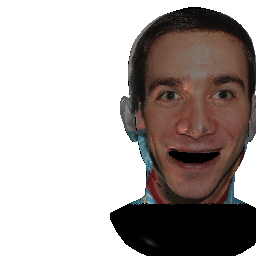

In [2]:
Image.fromarray((images[0].permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8))

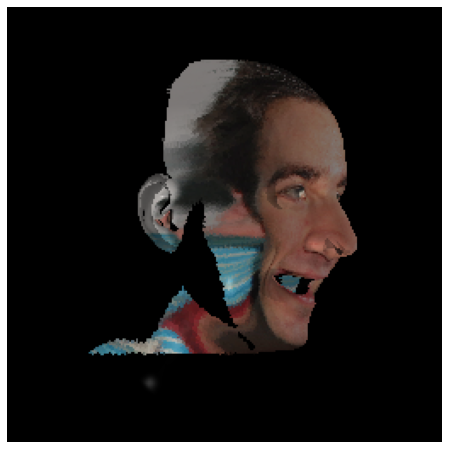

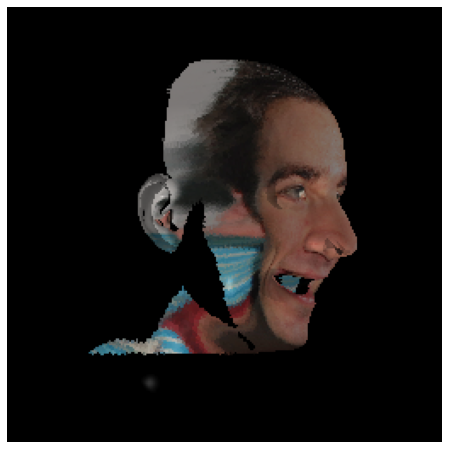

In [3]:
ckpt_filename = "../exp/ve/ffhq_256_ncsnpp_continuous/checkpoint_48.pth"
config = configs.get_config()
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5

batch_size = 1 #@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

def image_grid(x):
    size = config.data.image_size
    channels = config.data.num_channels
    img = x.reshape(-1, size, size, channels)
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
    return img


def show_samples(x):
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    img = image_grid(x)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.075 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
inverse_scaler = datasets.get_data_inverse_scaler(config)

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor,
                                                        corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)

show_samples(images)
show_samples(images * masks)
inpainted_images = pc_inpainter(score_model, scaler(images), masks)
show_samples(inpainted_images)


    